In [1]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)  # to  visualize which functions are assigned to which device(CPU or GPU)
# # by default, GPU is assigned priority for tensorflow. To disable it, run this:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from IPython.core import display
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from math import pi
import kdl as tk
from quaternion import *
from scipy.spatial.transform import Rotation as R

plt.style.use("default")
%matplotlib inline
%load_ext autoreload
%autoreload 2

Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Log in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0


### Setup of some functions and variables


In [3]:
def rotvec2mat(x):
    return R.as_matrix(R.from_rotvec(x))

In [4]:
# Loading the rivet positions in 3D position vectors
targets = np.load("targets.npy")

In [5]:
# Using tensorflow implementation of KDL, get the urdf, chain and dyn parameters
urdf = tk.urdf_from_file('panda_arm_kdl.urdf')
chain = tk.tk_chain_from_urdf(urdf)
dyn = tk.ChainDynParam(chain)


Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pow in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatrixDiagV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sqrt in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 

Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link0']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link1']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link2']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link4']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link5']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link6']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_link7']/collision[1]
Unknown tag "material" in /robot[@name='panda']/link[@name='panda_hand']/collision[1]


In [6]:
# Transformations from world frame(bullet) of the simulation to the robot frame(kdl):
# For Panda on the floor and for this paper, we used the same frame, but the user can change it from here.
base_pos = tf.cast(np.array([0., 0., 0.])[None], tf.float32)
base_rot_vec = np.array([0., 0., 0.])
base_rot_mat = tf.cast(rotvec2mat(base_rot_vec), tf.float32)
base_rot_mat_inv = tf.cast(tf.transpose(base_rot_mat), tf.float32)

def kdl2bullet_x(x):
    """
    param: x: [batch, 3] position in kdl (wrt robot base frame)
    return: [batch, 3] position in bullet (wrt bullet world frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat, x) + base_pos

def bullet2kdl_x(x):
    """
    param: x: [batch, 3] position in bullet (wrt bullet world frame)
    return: [batch, 3] position in kdl (wrt robot base frame)
    """
    return tf.einsum('ij, aj->ai',base_rot_mat_inv, x - base_pos)

def kdl2bullet_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in kdl (wrt robot base frame)
    return: [batch, 4] quaternion vector in bullet (wrt bullet world frame)
    """
    kdl_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    world_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat, kdl_end_rot_mat)
    return rot2quat(world_end_rot_mat)

def bullet2kdl_q(x):
    """
    param: x: [batch, 9] vectorized rotation matrix in bullet (wrt bullet world frame)
    return: [batch, 4] quaternion vector in kdl (wrt robot base frame)
    """
    world_end_rot_mat = tf.reshape(x, (x.shape[0], 3,3))
    kdl_end_rot_mat =  tf.einsum('ij, ajk->aik', base_rot_mat_inv, world_end_rot_mat)
    return rot2quat(kdl_end_rot_mat)
        
def kdl2bullet_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix in kdl (wrt robot base frame)
    return: [batch, 3], [batch, 4]  position, quaternion in bullet (wrt bullet world frame)
    """
    return kdl2bullet_x(x[:, :3]), kdl2bullet_q(x[:, 3:])

def bullet2kdl_xq(x):
    """
    param: x: [batch, 12] position + vectorized rotation matrix in bullet (wrt bullet world frame)
    return: [batch, 3], [batch, 4]  position, quaternion in kdl (wrt robot base frame)
    """
    return bullet2kdl_x(x[:, :3]), bullet2kdl_q(x[:, 3:])


Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0


### Defining the end-pose cost

In [7]:
# Quaternion cost
quats_xyz = Quaternion(create_unit_rotations(angle=pi/2))
u = tf.constant([0.        , np.pi/2, 0. ])       
theta = tf.linalg.norm(u)
u = u/theta
mu = tf.cast(utils.axis_angle2quats(u, theta), tf.float32)[None]

mu_  = Quaternion(tf.tile(mu, (3,1)))
rot_mu =  mu_ * quats_xyz
u = Quaternion(rot_mu) - mu_
u = u/tf.linalg.norm(u, axis=-1)[:,None]
norms = tf.constant([1, 1e-5, 1e-5])
cov = tf.reduce_sum(tf.einsum('k,kij->kij', 
                                  norms,
                                  tf.einsum('ki, kj->kij',u,u)), axis=0)
cov += 1e-6 * tf.eye(4)

prec = tf.linalg.inv(cov)
mu_quat = mu[None]
def normalS3_log_prob(x):
    """
    x : [hole_nb, batch_nb, 4]
    Quaternion lognormal distribution
    """
    mu__ = Quaternion(tf.tile(mu_quat, (x.q.shape[0], x.q.shape[1], 1)))
    diff = x - mu__
    quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec,diff))
    return quad


# Position cost
cov_x = tf.linalg.diag([1e-3, 1e-3, 1e-3])
prec_x = tf.linalg.inv(cov_x)

def normal_log_prob_(mu_x):
    """
    mu_x : [hole_nb, 1, 3]
    """
    def normal_log_prob(x):
        """
        x: [hole_nb, batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('hbi,hbi->hb',diff, tf.linalg.einsum('ij,hbj->hbi',prec_x,diff))
        return quad
    return normal_log_prob

def normal_log_prob__(mu_x):
    """
    mu_x : [1, 3]
    """
    def normal_log_prob(x):
        """
        x: [batch_nb, 3]
        Cartesian lognormal distribution
        """
        diff = x - mu_x
        quad = -0.5*tf.linalg.einsum('bi,bi->b',diff, tf.linalg.einsum('ij,bj->bi',prec_x,diff))
        return quad
    return normal_log_prob

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tile in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cross in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Minimum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Maximum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Acos in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:C

### Joint limit costs

In [8]:
joint_limits = tf.stack(chain.joint_limits)
lower_limits = joint_limits[:,0][None, None]
upper_limits = joint_limits[:,1][None, None]
def plot_limits(q):
    plt.plot(joint_limits, "o")
    plt.plot(q, "kx")
    
mean_limits = tf.reduce_mean(joint_limits,-1)[None]
@tf.function
def cost_joint_limit(q):
    rl = tf.math.minimum(q-lower_limits, 0)
    ru = tf.math.maximum(q-upper_limits, 0)
    return 0.5*(tf.linalg.einsum('hbi,hbi->hb',rl, rl) + tf.linalg.einsum('hbi,hbi->hb',ru, ru))


Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0


### Optimization to find the joint configuration corresponding to rivet hole positions within joint limits

In [9]:
batch = 100
mu_x = tf.cast(targets, tf.float32)[:, None]
normal_log_prob = normal_log_prob_(mu_x)
hole_nb = targets.shape[0]
@tf.function
def cost_ik(q):
    """
    q: [hole_nb, batch_nb, nb_dof]
    """
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    # if robot base frame is changed, uncomment this
    # world_end_pos, world_end_quats = kdl2bullet_xq(xs_)
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch, 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
        
    ee_pos_cost = -normal_log_prob(world_end_pos)
    ee_quat_cost = -normalS3_log_prob(Quaternion(world_end_quats))
    return ee_pos_cost +  ee_quat_cost*0.1 + cost_joint_limit(q)*1e3


In [10]:
# Start is the initial guess on the joint configurations within the joint limits
start  = tf.Variable(
    tf.random.uniform(shape=(hole_nb, batch, 7),
                      minval=tf.stack(chain.joint_limits)[:,0],
                      maxval=tf.stack(chain.joint_limits)[:,1]))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [11]:
@tf.function
def cost():
    return cost_ik(start)
optimizer = tf.keras.optimizers.Adam(0.5)

In [12]:
# Stochastic Gradient Descent
for i in range(1000000):
    try :
        optimizer.minimize(cost,[start] )
        display.clear_output(wait=True)
        tf.print(cost())
    except KeyboardInterrupt:
        break

[[9.95090199 0.0026755617 0.00179359142 ... 5.55308056 0.00321005145 9.99343501e-06]
 [0.0200813524 0.0159537364 1.5655809e-05 ... 0.00341105 0.00599131314 141.88385]
 [2.8488379e-05 0.0126329344 0.0208475925 ... 4.76485682 164.79657 0.000728779647]
 ...
 [0.221870631 0.0118331648 0.0246404782 ... 0.00632223347 11.3479061 21.3050823]
 [0.944929957 21.7428074 100.115677 ... 9.78999233 0.283266813 12.203618]
 [0.00210009352 77.2143707 8.71356773 ... 77.2211914 3.07926607 3.11710453]]


### Filtering to get converging solutions

In [13]:
# first version of the found joint configurations,
# some may not be within the joint limits nor correspond to rivet positions since the SGD did not converge
good_q__ = start
good_q__.shape

TensorShape([84, 100, 7])

In [14]:
# Second version containing all the solutions in the joint configuraitons
good_q_ = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q_[i] = good_q__[i][cost_joint_limit(good_q__)[i] < 1e-2]
    max_nb = min(max_nb,good_q_[i].shape[0])
    
for i in range(hole_nb):
    good_q_[i] = good_q_[i][:max_nb]
    
good_q_ = tf.stack(good_q_)
good_q_.shape

Executing op __inference_cost_joint_limit_2226 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Where in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/tas

TensorShape([84, 78, 7])

In [15]:
# This cell and the next cell can be used to see if the chosen configuration is within the joint limits-
i = 0 # rivet hole
j = 0 # configuration nb

Executing op __inference_cost_joint_limit_341431 in device /job:localhost/replica:0/task:0/device:CPU:0
[[0]]


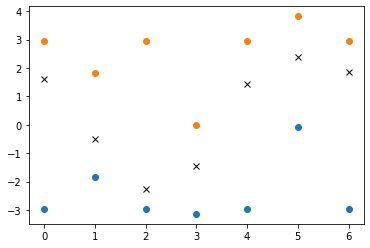

In [16]:
plot_limits(good_q_[i][j])
tf.print(cost_joint_limit(good_q_[i][j][None]))
j+=1
# i+=1

In [17]:
# A function to check if the configurations correspond to rivet positions within the tolerance
def check_q(q):
    batch = q.shape[1]
    q_vec = tf.reshape(q, (hole_nb*batch, q.shape[2]))
    xs_ = chain.xs(q_vec, layout=tk.FkLayout.xm)[:, -1]
    
    world_end_pos = tf.reshape(xs_[..., :3], (hole_nb, batch , 3))
    world_end_quats = rot2quat(tf.reshape(xs_[...,3:], (hole_nb*batch, 3, 3)))
    world_end_quats = tf.reshape(world_end_quats, (hole_nb, batch, 4))
    
    good_xs = [None for i in range(hole_nb)]
    good_xs_ind = [None for i in range(hole_nb)]
    max_nb = 1e5
    for i in range(hole_nb):
#         print(world_end_pos[i][normal_log_prob(world_end_pos)[i] > -1e-2].shape)
        good_xs[i] = world_end_pos[i][normal_log_prob(world_end_pos)[i] > -1e-1]
        good_xs_ind[i] = np.where(normal_log_prob(world_end_pos)[i] > -1e-1)
        max_nb = min(max_nb,good_xs[i].shape[0])

    for i in range(hole_nb):
        good_xs[i] = good_xs[i][:max_nb]

    good_xs = tf.stack(good_xs)
    return world_end_pos, good_xs, good_xs_ind
    

In [18]:
xs, good_xs, good_xs_ind = check_q(good_q_)
# xs : all the end positions corresponding to good_q_
# good_xs : all the end positions within the good tolerance corresponding to good_q_
good_xs.shape

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatrixDiagPartV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Einsum in device /job:localhost/replica:0/task:0/device

TensorShape([84, 31, 3])

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0


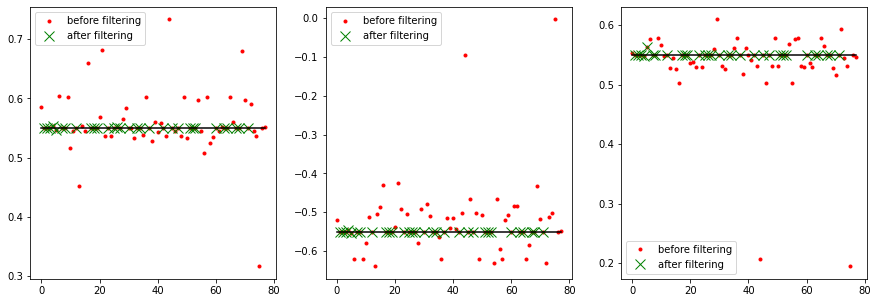

In [19]:
# Plotting good_xs
fig,ax = plt.subplots(ncols=3, figsize=(15,5))
N = xs.shape[1]
j = 0 # choose a rivet hole
for i in range(3):
    ax[i].plot(range(N), xs[j, :,i], "r.", label="before filtering")
    ax[i].plot(good_xs_ind[j][0][:good_xs.shape[1]], good_xs[j,:,i], "gx", ms=10, label="after filtering")
    ax[i].plot(range(N), [mu_x[j,:,i]]*N, "k")
    ax[i].legend()
# plt.legend()

In [20]:
# third version of the joint configurations, within joint limits and within the tolerance of corresponding rivet position
good_q = [None for i in range(hole_nb)]
max_nb = 1e5
for i in range(hole_nb):
    good_q[i] = good_q_[i][-normal_log_prob(xs)[i] < 1e-1]
    max_nb = min(max_nb,good_q[i].shape[0])
    
for i in range(hole_nb):
    good_q[i] = good_q[i][:max_nb]
    
good_q = tf.stack(good_q)
good_q.shape

TensorShape([84, 31, 7])

In [21]:
i = 0
j = 1

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
[[0]]


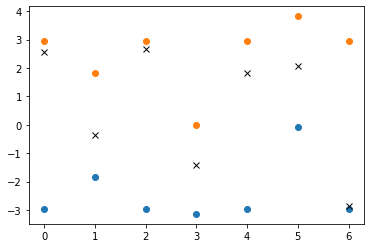

In [22]:
plot_limits(good_q[j,i])
tf.print(cost_joint_limit(good_q[j,i][None]))
i+=1

In [23]:
# check if there is any nan
if tf.where(tf.math.is_nan(good_q) == True).shape[0] == 0:
    print("no nan")
else:
    print("check nans")

Executing op IsNan in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
no nan


### Displacement cost

In [24]:
# Force: 
F = 150 # in Newton
nF = tf.constant([-1, 0., 0]) #direction of force in world frame coordinates

In [25]:
# For 7dof robot
K = tf.eye(chain.nb_joint)*1e5
C = tf.linalg.diag(tf.ones(7)*0.06)

# chosen frequency in rad/s
w = tf.constant(150.)

def compute_H(w, M, J, C, K):
    """
    Finds the displacement force frequency response function H(w)
    """
    real = -(w**2)*M+K
    imag = w*C
    comp = tf.complex(real, imag)
    try:
        inv = tf.linalg.inv(comp, adjoint=True)
    except:
        r0  = tf.linalg.pinv(real) @ imag
        y11 = tf.linalg.pinv(imag @ r0 + real)
        y10 = -r0 @ y11

        inv = tf.cast(tf.complex(y11,y10), dtype =comp.dtype)
    return J@inv@tf.transpose(J, (0,2,1))

def displacement(q):
        q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
        M = dyn.inertia_matrix(q_vec) 
        J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
        J = tf.complex(J, tf.zeros_like(J))
        H = compute_H(w, M, J, C, K)
        
        A = tf.transpose(H, perm=(0,2,1),conjugate=True)@H
        evals, evecs = tf.linalg.eigh(A)

        evals = tf.reshape(evals, (q.shape[0], q.shape[1], 3))
        return tf.math.sqrt(tf.math.abs(tf.math.real(evals)))

@tf.function
def displacement_(w, q):
        q_vec = tf.reshape(q, (q.shape[0]*q.shape[1], q.shape[2]))
        M = dyn.inertia_matrix(q_vec)
        J = chain.jacobian(q_vec, layout=tk.FkLayout.x)
        J = tf.complex(J, tf.zeros_like(J))
        H = compute_H(w, M, J, C, K)
        A = tf.transpose(H, (0,2,1),conjugate=True)@H
        evals, evecs = tf.linalg.eigh(A)
        evals = tf.reshape(evals, (q.shape[0], q.shape[1], 3))
        return  tf.math.sqrt(tf.math.abs(tf.math.real(evals)))

In [26]:
data_nb = 50
config_nb = 50
w__ = 450 # last frequency for the plotting
w_ = tf.cast(np.linspace(0, w__, data_nb), tf.float32)
disp = np.zeros((hole_nb, config_nb, data_nb))
disp_x = np.zeros((hole_nb, config_nb, data_nb, 3))
disp_x
q_random = tf.random.uniform(shape=(hole_nb, config_nb,7), minval=tf.stack(chain.joint_limits)[:,0],maxval=tf.stack(chain.joint_limits)[:,1])
for i in range(data_nb):
#     d_ = displacement_(w_[i], good_q[:,:config_nb])
    d_ = displacement_(w_[i], q_random[:,:config_nb])
#     disp[:,:, i] = tf.reduce_max(displacement_(w_[i], q_random), -1)
#     disp[:,:, i] = tf.reduce_max(d_, -1)
    disp_x[:,:,i] = d_


Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_displacement__358035 in device /job:localhost/replica:0/task:0/device:CPU:0


In [36]:
def forward(x):
    return x * 130.
def inverse(x):
    return x/130.
titles = ["In riveting direction", "Worst-case scenario(max)"]


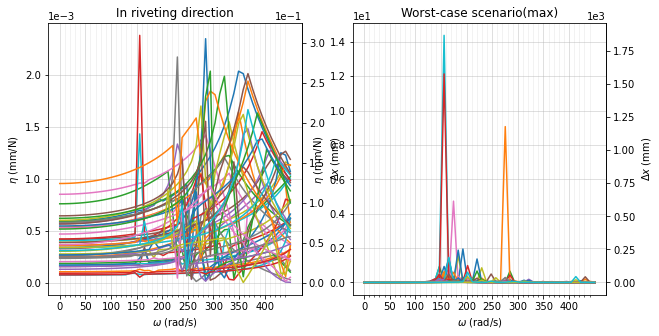

In [37]:
fig,axes = plt.subplots(ncols=2, figsize=(10,5))
k = 0
for disp,ax in zip([tf.einsum('abci,i->abc',disp_x, tf.constant([1., 0., 0.])), tf.reduce_max(disp_x, -1)], axes):
    
    for j in range(1):
        for i in range(config_nb):
            ax.plot(w_,disp[j,i]*1e3, "-", label="Point A")
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlabel('$\omega$'+' (rad/s)')
    ax.set_ylabel('$\eta$'+' (mm/N)')
    ax.grid("on")
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, w_[-1], 50)
    minor_ticks = np.arange(0, w_[-1], 10)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)


    secax = ax.secondary_yaxis('right', functions=(forward, inverse))
    secax.set_ylabel('$\Delta x$'+' (mm)')
    secax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    # And a corresponding grid
    ax.grid(which='both')

    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_title(titles[k])
    k += 1
    # ax.set_facecolor("w")
    # plt.legend()

### Optimization for displacement

In [39]:
# select batch to be equal or smaller to good_q.shape[1]
good_q.shape[1]

31

In [40]:
batch = 30
q_test = tf.Variable(good_q[:, :batch], trainable=True)
@tf.function
def cost_(): 
    return cost_ik(q_test)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [41]:
@tf.function
def train_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(q_test)
        disp_cost = tf.norm(displacement(q_test),ord=2,axis=-1 )
        loss = cost_ik(q_test) + 1e1*disp_cost
        
    grads = tape.gradient(loss, [q_test])
    grads_ = grads[0]
    # removing nans
    grads_ = tf.where(tf.math.is_nan(grads_), tf.zeros_like(grads_), grads_)
    optimizer.apply_gradients(zip([grads_], [q_test]))
    return loss, grads

In [42]:
optimizer = tf.keras.optimizers.Adam(0.05)

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [43]:
for i in range(1000000):
    try :
        loss, grads = train_step()
        display.clear_output(wait=True)
        tf.print(loss)
    except KeyboardInterrupt:
        break

[[0.00319373701 0.0046120421 0.00161069608 ... 0.00764251966 0.00615215255 0.00295724557]
 [0.0194557179 0.0164986 0.00268904981 ... 0.00192428159 0.00149234454 0.00508782919]
 [0.00270740176 0.014204789 0.00457148 ... 0.0198405255 0.00658478215 0.0156428497]
 ...
 [0.066472 0.014163875 0.00357513851 ... 0.005129606 0.00202657632 0.10964261]
 [0.00304808631 0.0802849531 0.0504727736 ... 0.00473322533 0.00186485134 0.00460544648]
 [0.00379401376 0.0197418071 0.00707324 ... 0.00969913229 0.0272822045 0.00298064784]]


In [46]:
# check if there is any nan
if tf.where(tf.math.is_nan(loss) == True).shape[0] == 0:
    print("no nan")
else:
    print("check nans")

no nan


In [48]:
# filter again for good riveting positions
xs_,_,_ = check_q(q_test)
print(xs_.shape)
i=0

(84, 30, 3)


In [49]:
j = 0

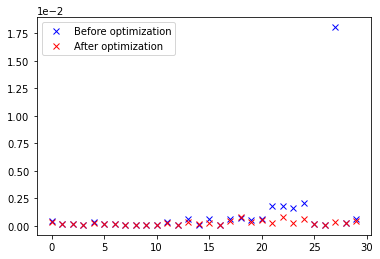

In [61]:
# run this cell many times to visualize the results for different rivet holes
plt.plot(tf.linalg.norm(displacement(good_q[j,:batch][None])[0],axis=-1), "bx", label="Before optimization")
plt.plot(tf.linalg.norm(displacement(q_test[j][None])[0],axis=-1), "rx", label="After optimization")
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
j+=1

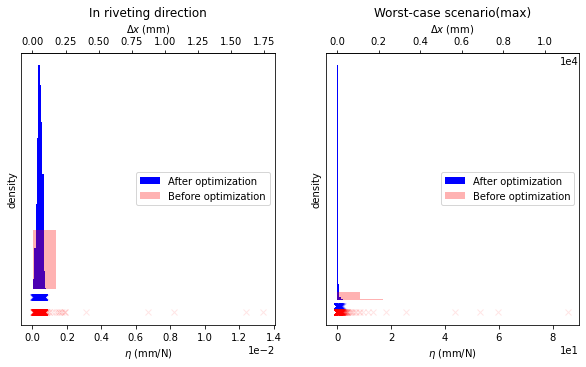

In [59]:
fig,axes=plt.subplots(ncols=2,figsize=(10,5))
density = 1
after_opt_data = displacement(q_test)*1e3
before_opt_data = displacement(good_q[:,:batch])*1e3
k = 0
for ax in axes:
    if k == 0:
        
        
        ax.hist(after_opt_data.numpy()[...,0].flatten(),density=density,color="b", label="After optimization")
        ax.hist(before_opt_data.numpy()[...,0].flatten(), color="r",density=density, alpha=0.3, label="Before optimization")
        ax.plot(after_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-100), "bx", alpha=0.1)
        ax.plot(before_opt_data.numpy()[...,0].flatten(), np.ones_like(after_opt_data.numpy()[...,0].flatten())*(-300), "rx", alpha=0.1)
      
    else:
        ax.hist(tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten(), density=density, color="b", label="After optimization")
        ax.hist(tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), density=density, alpha=0.3, color="r", label="Before optimization")
        ax.plot(after_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.1), "bx", alpha=0.1)
        ax.plot(before_opt_data.numpy().flatten(), np.ones_like(after_opt_data.numpy().flatten())*(-0.2), "rx", alpha=0.1)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlabel('$\eta$'+' (mm/N)')
    ax.set_ylabel("density")
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('$\Delta x$'+' (mm)')
    secax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.legend(loc=7)

    ax.set_yticks([])
    ax.set_title(titles[k])
    k += 1

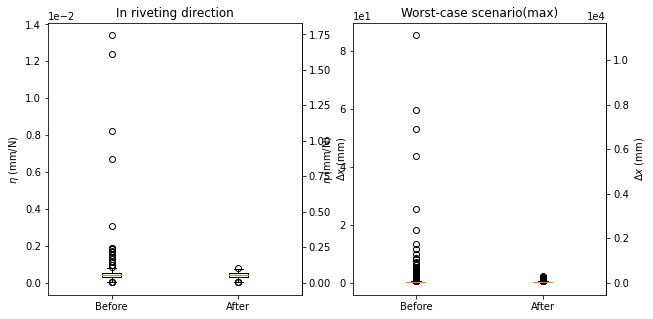

In [66]:
fig,axes = plt.subplots(ncols=2 , figsize=(10,5))
density = 1
k = 0
for ax in axes:
    
    after_opt_data = displacement(q_test)*1e3
    before_opt_data = displacement(good_q[:,:batch])*1e3
    if k == 0:
        ax.boxplot([ before_opt_data.numpy()[...,0].flatten(), after_opt_data.numpy()[...,0].flatten()])
    else:
        ax.boxplot([tf.linalg.norm(before_opt_data,axis=-1).numpy().flatten(), 
                    tf.linalg.norm(after_opt_data,axis=-1).numpy().flatten()])

    ticks = ["Before", "After"]
    ax.set_xticks([1,2])
    ax.set_xticklabels( ticks, rotation=0 )
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel('$\eta$'+' (mm/N)')

    secax = ax.secondary_yaxis('right', functions=(forward, inverse))
    secax.set_ylabel('$\Delta x$'+' (mm)')
    secax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title(titles[k])
    k +=1